In [1]:
# Importing necessary libraries for the project

import os
from ast import increment_lineno
from xml.etree.ElementInclude import include
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import math

In [2]:
#Calibrating the libraries for visual aid

sns.set_style("whitegrid")
sns.set_context("paper",font_scale=1.0)
pd.options.display.max_rows = 1000 #Truncates the rows if they are over 100
pd.options.display.max_columns = 100 #Truncates the columns if they are over 100
pd.options.display.float_format = '{:.2f}'.format #Only displays upto 2 decimal points for numericals

import warnings
warnings.filterwarnings('ignore')

In [20]:
#Loading the dataset and printing first few rows

df = pd.read_csv('./Credit_Score_Classification/data/train.csv')
print(df.head())

df.columns = [x.lower() for x in df.columns]

       ID Customer_ID     Month           Name   Age          SSN Occupation  \
0  0x1602   CUS_0xd40   January  Aaron Maashoh    23  821-00-0265  Scientist   
1  0x1603   CUS_0xd40  February  Aaron Maashoh    23  821-00-0265  Scientist   
2  0x1604   CUS_0xd40     March  Aaron Maashoh  -500  821-00-0265  Scientist   
3  0x1605   CUS_0xd40     April  Aaron Maashoh    23  821-00-0265  Scientist   
4  0x1606   CUS_0xd40       May  Aaron Maashoh    23  821-00-0265  Scientist   

  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  \
0      19114.12                1824.84                  3                4   
1      19114.12                    NaN                  3                4   
2      19114.12                    NaN                  3                4   
3      19114.12                    NaN                  3                4   
4      19114.12                1824.84                  3                4   

   Interest_Rate Num_of_Loan  \
0              3  

In [21]:
#Checking data quality

print(df.shape)

(100000, 28)


In [22]:
#Dropping not needed columns

df.drop(['id','customer_id','month','name','ssn','type_of_loan','credit_history_age'],axis=1,inplace=True)

In [23]:
#Checking for duplicates

print(df.info())
print(df.duplicated().value_counts()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age                       100000 non-null  object 
 1   occupation                100000 non-null  object 
 2   annual_income             100000 non-null  object 
 3   monthly_inhand_salary     84998 non-null   float64
 4   num_bank_accounts         100000 non-null  int64  
 5   num_credit_card           100000 non-null  int64  
 6   interest_rate             100000 non-null  int64  
 7   num_of_loan               100000 non-null  object 
 8   delay_from_due_date       100000 non-null  int64  
 9   num_of_delayed_payment    92998 non-null   object 
 10  changed_credit_limit      100000 non-null  object 
 11  num_credit_inquiries      98035 non-null   float64
 12  credit_mix                100000 non-null  object 
 13  outstanding_debt          100000 non-null  ob

In [24]:
# Checking for null values in the dataset next
print(df.isnull().sum().reset_index().rename(columns={'index': 'feature_name',0: 'null_counts'}))
print(df.shape[0])

                feature_name  null_counts
0                        age            0
1                 occupation            0
2              annual_income            0
3      monthly_inhand_salary        15002
4          num_bank_accounts            0
5            num_credit_card            0
6              interest_rate            0
7                num_of_loan            0
8        delay_from_due_date            0
9     num_of_delayed_payment         7002
10      changed_credit_limit            0
11      num_credit_inquiries         1965
12                credit_mix            0
13          outstanding_debt            0
14  credit_utilization_ratio            0
15     payment_of_min_amount            0
16       total_emi_per_month            0
17   amount_invested_monthly         4479
18         payment_behaviour            0
19           monthly_balance         1200
20              credit_score            0
100000


In [25]:
#Dropping null values
#The below code filters the DataFrame df by keeping only those rows where the sum of NaN values across columns is less than 3. It drops rows that have more than 2 NaN values.
#$
size_before_cleaning = df.shape
df = df[df.isnull().sum(axis=1) < 3]
print(f"{size_before_cleaning[0] - df.shape[0]} records dropped")



def amount_invested_monthly(col):
    if "__" in str(col):
        return str(col).split("_")[1]
    else:
        return str(col)
    
df["amount_invested_monthly"] = df["amount_invested_monthly"].apply(amount_invested_monthly)
df["amount_invested_monthly"].replace('', np.nan, inplace=True)

# Drop rows with NaN in the "amount_invested_monthly" column
df.dropna(subset=["amount_invested_monthly"], inplace=True)
# Convert the column to float
df["amount_invested_monthly"] = df["amount_invested_monthly"].astype(float)

df["amount_invested_monthly"] = df["amount_invested_monthly"].astype("float")

def filter_delayed_payments(value):
    if "_" in str(value):
        return str(value).split("_")[1]
    elif "-" in str(value):
        return str(value).replace("-","")
    elif str(value) == "_":
        return str(value)
    else:
        return str(value)

df["num_of_delayed_payment"] = df["num_of_delayed_payment"].apply(filter_delayed_payments)
df["num_of_delayed_payment"].replace('', np.nan, inplace=True)
df["num_of_delayed_payment"] = df["num_of_delayed_payment"].astype("float")

df["num_of_delayed_payment"].fillna(df["num_of_delayed_payment"].median(), inplace=True)



def filter_general(value):
    if '-' in str(value):
        return str(value).split('-')[1]
    elif '_' in str(value):
        return str(value).split('_')[0]
    else:
        return str(value)
    
df.drop(df[df["monthly_balance"]=="__-333333333333333333333333333__"].index,inplace=True)

for i in ['age','annual_income','num_of_loan','outstanding_debt','monthly_balance']:
    df[i] = df[i].apply(filter_general)
    df[i] = df[i].astype(np.float64)
    print(i + " Successfully Cleaned")

df = df[df['age'] <= 120]
df = df[df['num_bank_accounts'] <= 20]
df = df[df['num_credit_card'] <= 20]
df = df[df['num_of_loan'] <= 20]


df['occupation'] = df['occupation'].replace('_______',np.nan)
df["occupation"] = df["occupation"].fillna(np.random.choice(pd.Series(['Scientist','Teacher','Engineer','Entrepreneur','Developer','Lawyer','Media_Manager','Doctor','Journalist','Manager','Accountant','Musician','Mechanic','Writer','Architect'])))


df['credit_mix'] = df['credit_mix'].replace('_',np.nan)
df['credit_mix'] = df['credit_mix'].fillna(np.random.choice(pd.Series(['Standard','Good','Bad'])))


df['payment_of_min_amount'] = df['payment_of_min_amount'].replace('NM',np.nan)
df['payment_of_min_amount'] = df['payment_of_min_amount'].fillna(np.random.choice(pd.Series(['Yes','No'])))

# df['payment_behaviour'] = df['payment_behaviour'].replace() 

df['payment_behaviour'] = df['payment_behaviour'].replace('!@9#%8',np.nan)
df['payment_behaviour'] = df['payment_behaviour'].fillna(np.random.choice(pd.Series(['High_spent_Small_value_payments','Low_spent_Large_value_payments','High_spent_Large_value_payments','High_spent_Medium_value_payments','Low_spent_Large_value_payments','Low_spent_Small_value_payments','Low_spent_Medium_value_payments'])))
# print(df['payment_behaviour'].isnull().sum())
df["changed_credit_limit"] = df["changed_credit_limit"].apply(lambda x:x.split("-")[-1])
#So, the entire line is transforming each element in the 'changed_credit_limit' column by splitting it at '-' and keeping only the last part. The result is a new column with the extracted values.
df.drop(df[df["changed_credit_limit"].str.contains("_")].index, inplace=True)
#Next,we drop the rows with values "_"
df["changed_credit_limit"] = df["changed_credit_limit"].astype("float")
#Then,we convert the data type of the column to float

for i in ['monthly_inhand_salary',"amount_invested_monthly",'num_credit_inquiries','monthly_balance']:
    df[i] = df[i].fillna(df[i].median())

101 records dropped
age Successfully Cleaned
annual_income Successfully Cleaned
num_of_loan Successfully Cleaned
outstanding_debt Successfully Cleaned
monthly_balance Successfully Cleaned


In [26]:
#EDA
#The data is then split in 2 types categorical data and numerical data
print(df.info())

df_cat = df.select_dtypes(include='object')
df_num = df.select_dtypes(include='number')
print(df_num.info())
print(df_cat.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83937 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       83937 non-null  float64
 1   occupation                83937 non-null  object 
 2   annual_income             83937 non-null  float64
 3   monthly_inhand_salary     83937 non-null  float64
 4   num_bank_accounts         83937 non-null  int64  
 5   num_credit_card           83937 non-null  int64  
 6   interest_rate             83937 non-null  int64  
 7   num_of_loan               83937 non-null  float64
 8   delay_from_due_date       83937 non-null  int64  
 9   num_of_delayed_payment    83937 non-null  float64
 10  changed_credit_limit      83937 non-null  float64
 11  num_credit_inquiries      83937 non-null  float64
 12  credit_mix                83937 non-null  object 
 13  outstanding_debt          83937 non-null  float64
 14  credit

In [27]:
#The below code gives the count of unique values in each column of the categorical columns that we have
for col in df_cat:
    print(df_cat[col].value_counts())
    print('\n---------------------------')

Doctor           10984
Lawyer            5487
Mechanic          5333
Architect         5309
Scientist         5297
Engineer          5297
Accountant        5268
Teacher           5258
Developer         5216
Entrepreneur      5196
Media_Manager     5193
Journalist        5114
Musician          5006
Manager           5003
Writer            4976
Name: occupation, dtype: int64

---------------------------
Standard    47609
Good        20363
Bad         15965
Name: credit_mix, dtype: int64

---------------------------
Yes    53984
No     29953
Name: payment_of_min_amount, dtype: int64

---------------------------
Low_spent_Small_value_payments      27729
High_spent_Medium_value_payments    14706
Low_spent_Medium_value_payments     11667
High_spent_Large_value_payments     11494
High_spent_Small_value_payments      9546
Low_spent_Large_value_payments       8795
Name: payment_behaviour, dtype: int64

---------------------------
Standard    44705
Poor        24339
Good        14893
Name: credi

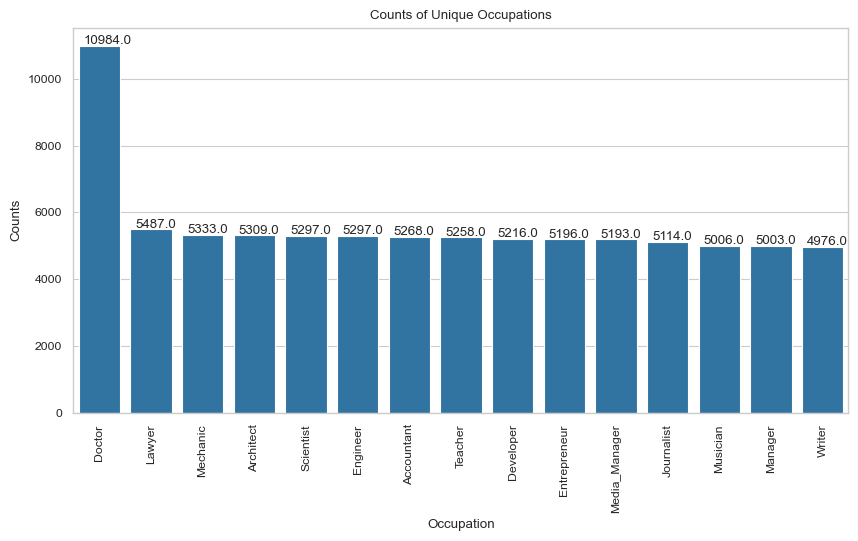

In [28]:
#Visualising Occupation

plt.figure(figsize=(10,5))
ax = sns.countplot(x='occupation',data=df_cat,order=df['occupation'].value_counts().index)
plt.title('Counts of Unique Occupations')
plt.xlabel('Occupation')
plt.ylabel('Counts')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()),(p.get_x()+0.1,p.get_height()+50))

plt.xticks(rotation=90)
plt.show()

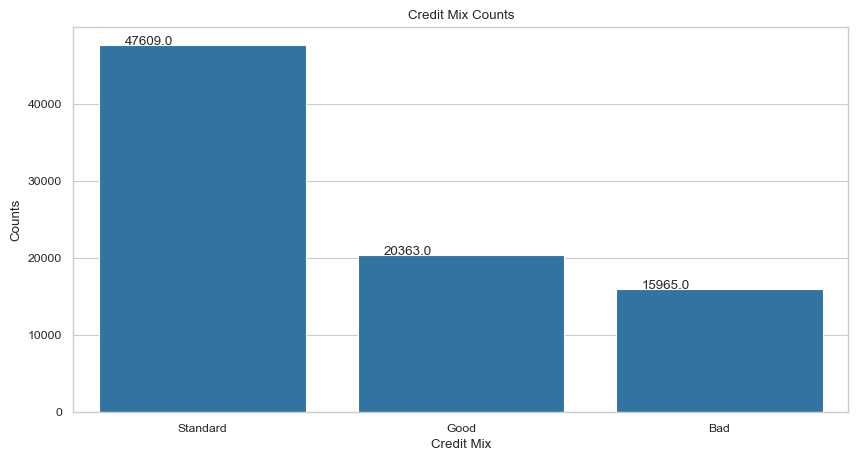

In [29]:
#Visualising Credit Mix

plt.figure(figsize=(10,5))
ax = sns.countplot(x='credit_mix',data=df_cat,order=df['credit_mix'].value_counts().index)
plt.title('Credit Mix Counts')
plt.xlabel('Credit Mix')
plt.ylabel('Counts')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()),(p.get_x()+0.1,p.get_height()+50))

# plt.xticks(rotation=90)
plt.show()

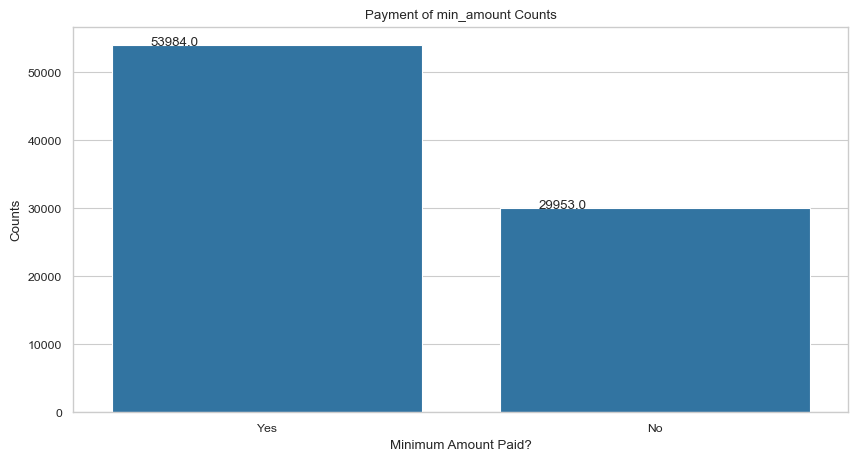

In [30]:
#Visualising Payment of Minimum Amount

plt.figure(figsize=(10,5))
ax = sns.countplot(x='payment_of_min_amount',data=df_cat,order=df['payment_of_min_amount'].value_counts().index)
plt.title('Payment of min_amount Counts')
plt.xlabel('Minimum Amount Paid?')
plt.ylabel('Counts')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()),(p.get_x()+0.1,p.get_height()+50))

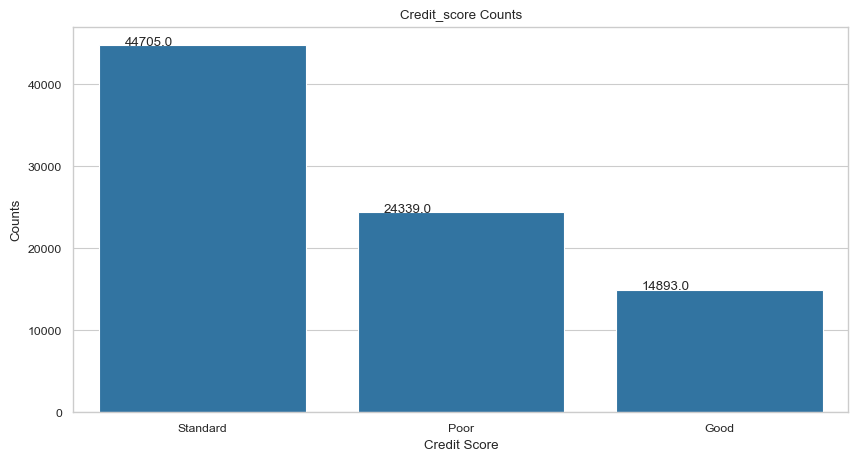

In [31]:
#Visualising Credit Score

plt.figure(figsize=(10,5))
ax = sns.countplot(x='credit_score',data=df_cat,order=df['credit_score'].value_counts().index)
plt.title('Credit_score Counts')
plt.xlabel('Credit Score')
plt.ylabel('Counts')
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()),(p.get_x()+0.1,p.get_height()+50))
# plt.xticks(rotation=45)
plt.show()


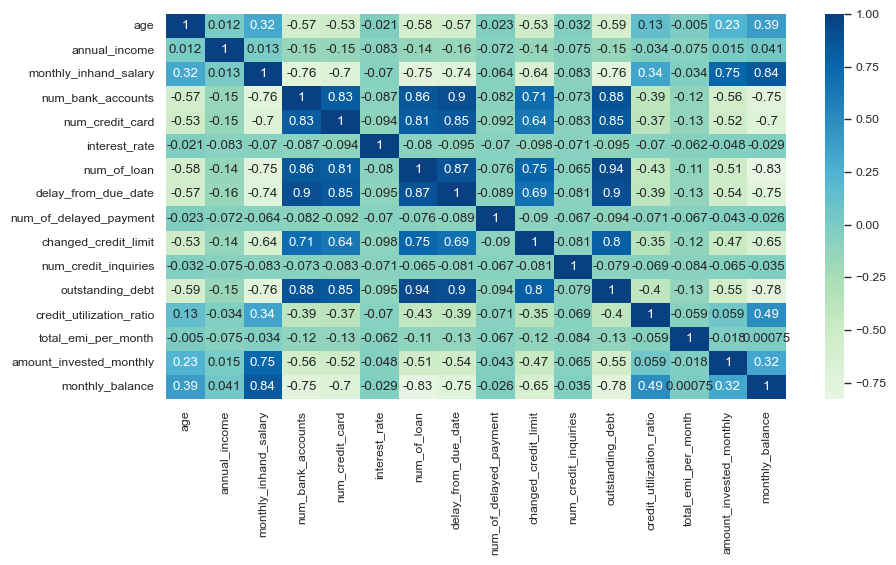

In [32]:
# #Correlation Heatmap for numerical dataframe

corr = df_num.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr.corr(),cmap="GnBu",center=0,annot=True)
plt.show()


In [40]:
# VIF(Variance Inflation Factor)
# We will only consider the numeric columns to compute this
vif_df = df[numeric_cols]
print(vif_df.describe())
X = sm.add_constant(vif_df)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Calculate VIF

# sm.OLS(X[col], X.drop(col, axis=1)): sm refers to the statsmodels library, and OLS stands for Ordinary Least Squares, which is a method for estimating the parameters of a linear regression model.
# For each iteration, this part of the code fits a simple linear regression model where the current column (col) is the dependent variable, and all other columns (excluding the current one) are independent variables.
# fit(): This method fits the linear regression model to the data.
# .rsquared: The rsquared attribute retrieves the coefficient of determination for the fitted regression model.It measures the proportion of the variance in the dependent variable explained by the independent variables.
# The entire formula for VIF is 1/1-R^2
# VIF scores for each variables indicate Athe extent to which the variance of each variable is inflated due to potential multicollinearity with other independent variables. Higher VIF values suggest a higher degree of multicollinearity for the corresponding variable.

vif_values = [1 / (1 - sm.OLS(X[col], X.drop(col, axis=1)).fit().rsquared) for col in X.columns[1:]]

# Create DataFrame
vif_data = pd.DataFrame({'feature': X.columns[1:], 'VIF': vif_values})

print(vif_data)

           age  annual_income  monthly_inhand_salary  num_bank_accounts  \
count 83937.00       83937.00               83937.00           83937.00   
mean     33.33      177495.08                4030.66               5.37   
std      10.81     1435683.29                2963.07               2.59   
min      14.00        7005.93                 303.65              -1.00   
25%      24.00       19436.31                1791.16               3.00   
50%      33.00       37580.34                3094.83               5.00   
75%      42.00       72814.86                5376.24               7.00   
max     118.00    24198062.00               15204.63              18.00   

       num_credit_card  interest_rate  num_of_loan  delay_from_due_date  \
count         83937.00       83937.00     83937.00             83937.00   
mean              5.53          73.03         3.54                21.07   
std               2.07         471.23         2.45                14.87   
min               0.00  

In [37]:
# We will now remove the features with vif greater than 2 as values above 2 are seen as a signal that there may be multicollinearity issues.
#This is how the data looks after deleting the columns 
print(df.head())

    age occupation  annual_income  monthly_inhand_salary  num_bank_accounts  \
0 23.00  Scientist       19114.12                1824.84                  3   
1 23.00  Scientist       19114.12                3094.83                  3   
3 23.00  Scientist       19114.12                3094.83                  3   
4 23.00  Scientist       19114.12                1824.84                  3   
5 23.00  Scientist       19114.12                3094.83                  3   

   num_credit_card  interest_rate  num_of_loan  delay_from_due_date  \
0                4              3         4.00                    3   
1                4              3         4.00                   -1   
3                4              3         4.00                    5   
4                4              3         4.00                    6   
5                4              3         4.00                    8   

   num_of_delayed_payment  changed_credit_limit  num_credit_inquiries  \
0                    7.00

In [38]:
# Data Preparation

X = df.drop('credit_score', axis=1)  # Features

# This line creates a new DataFrame X by dropping the column 'credit_score' from the original DataFrame df. The axis=1 parameter indicates that we are dropping a column (as opposed to a row).
# Here, a Series y is created, representing the target variable 'credit_score' from the original DataFrame df.
y = df['credit_score']  # Target variable




# Split the data into training and testing sets
# We will take 20% data as test data
# This line uses the train_test_split function from scikit-learn to split the data into training and testing sets. 
# X_train and y_train are the features and target variable for the training set, and X_test and y_test are the features and target variable for the testing set.
# The test_size=0.2 parameter indicates that 20% of the data will be used for testing, and random_state=42 ensures reproducibility by fixing the random seed.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# This line of the code uses the select_dtypes method of the DataFrame X_train to select columns of numeric data types.We then select the column names with
# .columns method.Then we will use .tolist() method to convert 
numeric_cols_train = X_train.select_dtypes(include=['number']).columns.tolist()


# This is a list comprehension that iterates over each column name (col) in the numeric_cols list.
# It includes only those columns for which the column name is also present in the numeric_cols_train list
numeric_cols = [col for col in numeric_cols if col in numeric_cols_train]


# We use one-hot encoding for our categorical features to make them binary
# One hot encoding basically converts the columns into binary form very each categorical column has either 0 or 1 as the value

X_train_encoded = pd.get_dummies(X_train, columns=['occupation', 'credit_mix', 'payment_of_min_amount', 'payment_behaviour'])
X_test_encoded = pd.get_dummies(X_test, columns=['occupation', 'credit_mix', 'payment_of_min_amount', 'payment_behaviour'])



# Creates an instance of the StandardScaler class.

scaler = StandardScaler()

# The fit_transform method is called on the scaler, which fits the scaler to the training data (X_train_encoded[numeric_cols]) and then transforms it. 
# This means it calculates the mean and standard deviation of the numeric columns in X_train_encoded and applies the transformation to standardize these columns.
# The result is assigned back to the corresponding columns in X_train_encoded.

X_train_encoded[numeric_cols] = scaler.fit_transform(X_train_encoded[numeric_cols])

# Here, the same scaler instance is used to transform the numeric columns in the test dataset 

X_test_encoded[numeric_cols] = scaler.transform(X_test_encoded[numeric_cols])


Accuracy: 0.6296759590183464
              precision    recall  f1-score   support

        Good       0.54      0.51      0.53      3031
        Poor       0.64      0.47      0.54      4784
    Standard       0.65      0.76      0.70      8973

    accuracy                           0.63     16788
   macro avg       0.61      0.58      0.59     16788
weighted avg       0.63      0.63      0.62     16788



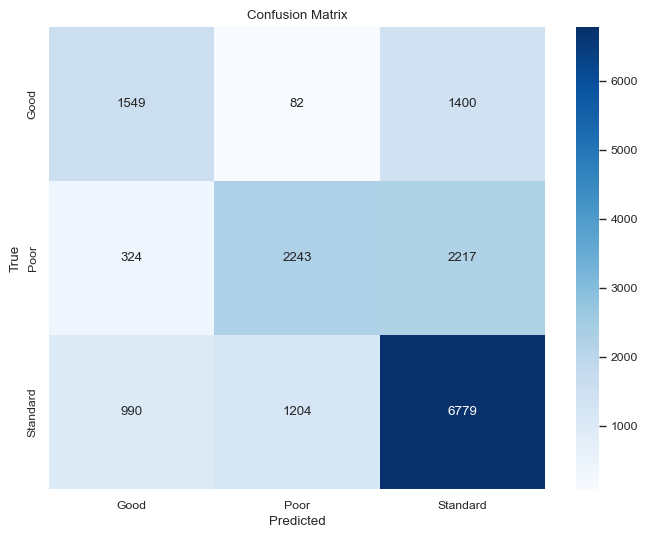

In [39]:
# Model-Logistic Regression


# This creates an instance of the logistic regression model

logreg = LogisticRegression()

# This line fits (trains) the logistic regression model on the training data.

logreg.fit(X_train_encoded, y_train)

# The predict method of the logistic regression model takes the preprocessed test data (X_test_encoded) as input and returns an array of predicted labels (y_pred).
# Each element in y_pred corresponds to the predicted class label for the corresponding row in the test dataset.

y_pred = logreg.predict(X_test_encoded)


# Create a DataFrame to display actual and predicted values side by side

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})


# It calculates the accuracy of the model's predictions by comparing the predicted labels (y_pred) with the actual labels (y_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


# It generates a text report with various classification metrics, such as precision, recall, and F1-score, for each class in your classification problem.
# It provides a more detailed view of the model's performance than accuracy alone.
# Precision - Precision checks how many predicted positives are actually positive?
# Recall -  Recall checks how many actual positives did we capture in our predictions?
# F1-score -  2 * (Precision * Recall) / (Precision + Recall).It is the harmonic mean of recall and precision.
# F1-score considers both false positives and false negatives, providing a single score that balances precision and recall

print(classification_report(y_test, y_pred))

# It calculates the confusion matrix using the confusion_matrix function from scikit-learn's metrics module. 
# A confusion matrix is a table that summarizes the performance of a classification algorithm.
# It shows the counts of true positive, true negative, false positive, and false negative predictions.

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

